### Installation the Libraries

In [9]:
!pip install opendatasets --upgrade --quiet

### Import Libraries


In [6]:
od.download("https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: khalidmohamed12
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


100%|██████████| 2.29G/2.29G [01:56<00:00, 21.2MB/s]


### F.2 Some of the Incorrectly Predicted Class

In [1]:
pip install --upgrade tensorflow keras

In [2]:
pip install opendatasets

In [11]:
# Importing necessary libraries
import os
from os.path import join, isdir
import opendatasets as od
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from pathlib import Path

In [12]:
# Downloading the dataset
od.download("https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia")

# Directories for the data
base_dir = Path("chest-xray-pneumonia/chest_xray/chest_xray/")
train_dir = base_dir / "train/"
val_dir = base_dir / "val/"
test_dir = base_dir / "test/"

Skipping, found downloaded files in "./chest-xray-pneumonia" (use force=True to force download)


In [13]:
# Checking TensorFlow version and GPU availability
print("TensorFlow version:", tf.__version__)
device_name = tf.config.list_physical_devices('GPU')
if not device_name:
    raise SystemError('GPU device not found')
print('Found GPU:', device_name)

TensorFlow version: 2.17.0
Found GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
# Directory listings
print(os.listdir(train_dir))

# Setting paths for test directories
test_normal_dir = test_dir / "NORMAL"
test_pneumonia_dir = test_dir / "PNEUMONIA"

['.DS_Store', 'NORMAL', 'PNEUMONIA']


In [15]:
# Loading training data
train_normal = list(train_dir.glob("NORMAL/*.jpeg"))
train_pneumonia = list(train_dir.glob("PNEUMONIA/*.jpeg"))
train_set = [(img, 0) for img in train_normal] + [(img, 1) for img in train_pneumonia]

# Creating DataFrame for training data
train_set = pd.DataFrame(train_set, columns=["image", "label"]).sample(frac=1).reset_index(drop=True)

# Loading validation data
valid_normal = list(val_dir.glob("NORMAL/*.jpeg"))
valid_pneumonia = list(val_dir.glob("PNEUMONIA/*.jpeg"))
valid_set = [(img, 0) for img in valid_normal] + [(img, 1) for img in valid_pneumonia]

# Creating DataFrame for validation data
valid_set = pd.DataFrame(valid_set, columns=["image", "label"]).sample(frac=1).reset_index(drop=True)

# Loading test data
test_normal = list(test_normal_dir.glob("*.jpeg"))
test_pneumonia = list(test_pneumonia_dir.glob("*.jpeg"))
test_set = [(img, 0) for img in test_normal] + [(img, 1) for img in test_pneumonia]

# Creating DataFrame for test data
test_set = pd.DataFrame(test_set, columns=["image", "label"]).sample(frac=1).reset_index(drop=True)

Total number of normal images: 1341
Total number of pneumonia images: 3875


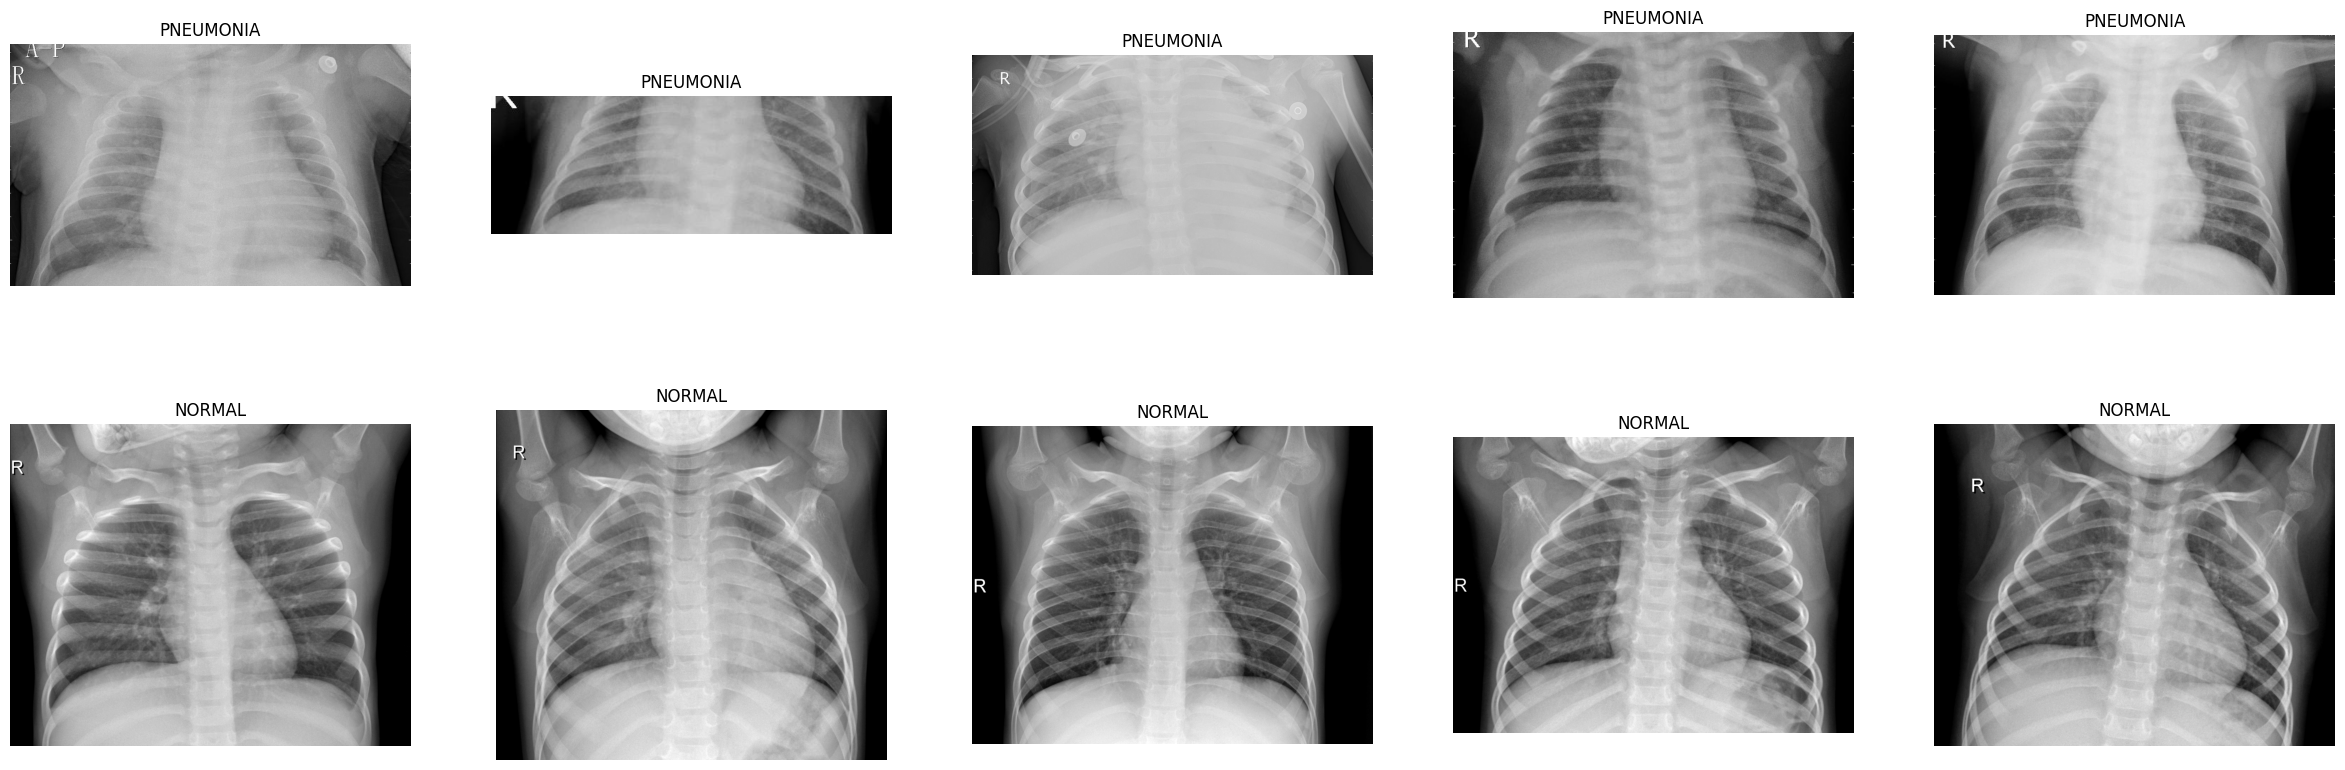

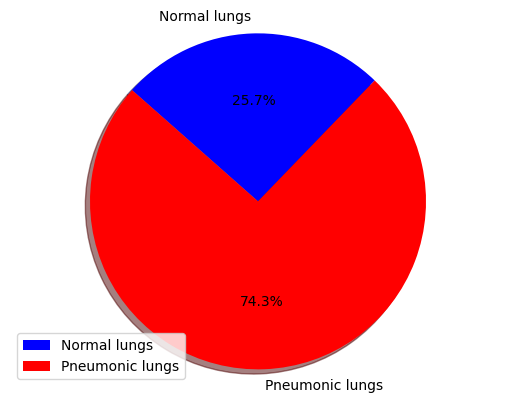

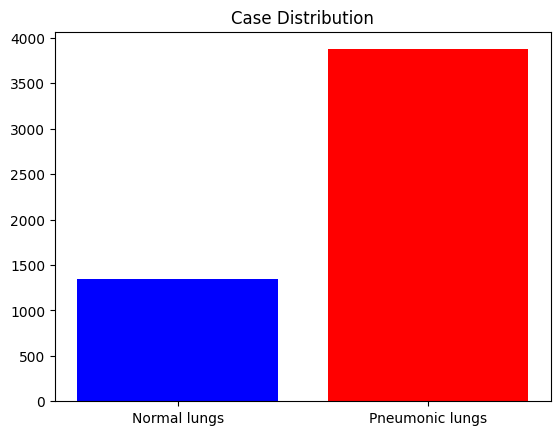

In [16]:
# Data visualization
train_normal_count = train_set.loc[train_set["label"] == 0]["image"].count()
train_pneumonia_count = train_set.loc[train_set["label"] == 1]["image"].count()
print("Total number of normal images:", train_normal_count)
print("Total number of pneumonia images:", train_pneumonia_count)

# Visualization of sample images
pneumonia_samples = list(train_set[train_set["label"] == 1]["image"].iloc[:5])
normal_samples = list(train_set[train_set["label"] == 0]["image"].iloc[:5])
samples = pneumonia_samples + normal_samples

fig, ax = plt.subplots(2, 5, figsize=(30, 10))
for i in range(10):
    img = imread(samples[i])
    ax[i // 5, i % 5].imshow(img, cmap='gray')
    if i < 5:
        ax[i // 5, i % 5].set_title("PNEUMONIA")
    else:
        ax[i // 5, i % 5].set_title("NORMAL")
    ax[i // 5, i % 5].axis('off')
plt.show()

fig1, ax1 = plt.subplots()
sizes = [train_normal_count, train_pneumonia_count]
ax1.pie(sizes, startangle=46, labels=["Normal lungs", "Pneumonic lungs"], autopct="%1.1f%%", shadow=True, colors=["b", "r"])
ax1.axis("equal")
plt.legend()
plt.show()

fig2, ax2 = plt.subplots()
ax2.bar(height=sizes, x=["Normal lungs", "Pneumonic lungs"], color=["blue", "red"])
plt.title("Case Distribution")
plt.show()

In [17]:
import cv2
import os
import numpy as np
from skimage.io import imread

# قائمة التسميات وحجم الصورة
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            if img.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img_arr = imread(os.path.join(path, img), as_gray=True)
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    data.append([resized_arr, class_num])
                except Exception as e:
                    print(f"Error processing image {img}: {e}")
    return np.array(data, dtype=object)

# تحميل البيانات
train = get_training_data(train_dir)
test = get_training_data(test_dir)
val = get_training_data(val_dir)

# تقسيم الميزات والتسميات
X_train, X_val, X_test = [], [], []
y_train, y_val, y_test = [], [], []

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)
for feature, label in val:
    X_val.append(feature)
    y_val.append(label)
for feature, label in test:
    X_test.append(feature)
    y_test.append(label)

# تطبيع البيانات
X_train = np.array(X_train) / 255.0
X_val = np.array(X_val) / 255.0
X_test = np.array(X_test) / 255.0

# إعادة تشكيل البيانات لتناسب النموذج
X_train = X_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)
X_val = X_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)
X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [18]:
# Data augmentation
image_generator = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)
image_generator.fit(X_train)

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np

# تحديد حجم الصورة (يمكن تعديلها بناءً على بياناتك)
img_size = 150

# بناء نموذج CNN
model = Sequential([
    Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(img_size, img_size, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2, padding='same'),
    Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
    Dropout(0.1),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2, padding='same'),
    Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2, padding='same'),
    Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2, padding='same'),
    Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2, padding='same'),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# تجميع النموذج
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# ملخص النموذج
model.summary()

# إعداد ImageDataGenerator لزيادة البيانات
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# حساب أوزان الفئات
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

# إعداد المولد للصور
train_generator = datagen.flow(X_train, y_train, batch_size=32)

# إعداد النداءات (callbacks)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# تدريب النموذج
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=(X_val, y_val),
    verbose=1,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)                   │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 38, 38, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 19, 19, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_44 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 10, 10, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_45 (MaxPooling2D)      │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 6400)                │              

 Total params: 3,705,282 (14.13 MB)

 Trainable params: 3,704,194 (14.13 MB)

 Non-trainable params: 1,088 (4.25 KB)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - accuracy: 0.7653 - loss: 2.0128 - val_accuracy: 0.5000 - val_loss: 21.5799 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.8527 - loss: 0.3093 - val_accuracy: 0.5000 - val_loss: 17.7379 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.8604 - loss: 0.3064 - val_accuracy: 0.5000 - val_loss: 1.2786 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.8915 - loss: 0.2584 - val_accuracy: 0.5000 - val_loss: 11.9667 - learning_rate: 0.0010
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.8991 - loss: 0.2725 - val_accuracy: 0.5000 - val_loss: 5.8257 - learning_rate: 0.0010
Epoch 6/20
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8927 - loss: 0.2635
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.8928 - loss: 0.26

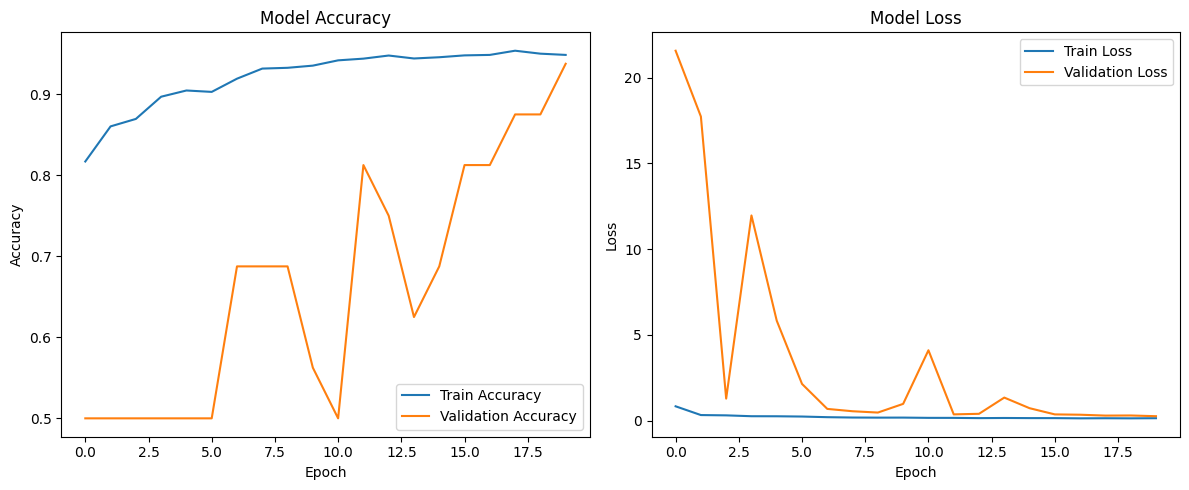

In [36]:
import matplotlib.pyplot as plt

# استخراج بيانات التاريخ (history)
history_dict = history.history

# رسم دقة النموذج
plt.figure(figsize=(12, 5))

# رسم دقة التدريب والاختبار
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# رسم خطأ النموذج
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# عرض الرسوم البيانيةالب
plt.tight_layout()
plt.show()

20/20 - 3s - 171ms/step - accuracy: 0.9087 - loss: 0.2380
Test accuracy: 0.9087
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
              precision    recall  f1-score   support

   PNEUMONIA       0.93      0.92      0.93       390
      NORMAL       0.87      0.89      0.88       234

    accuracy                           0.91       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



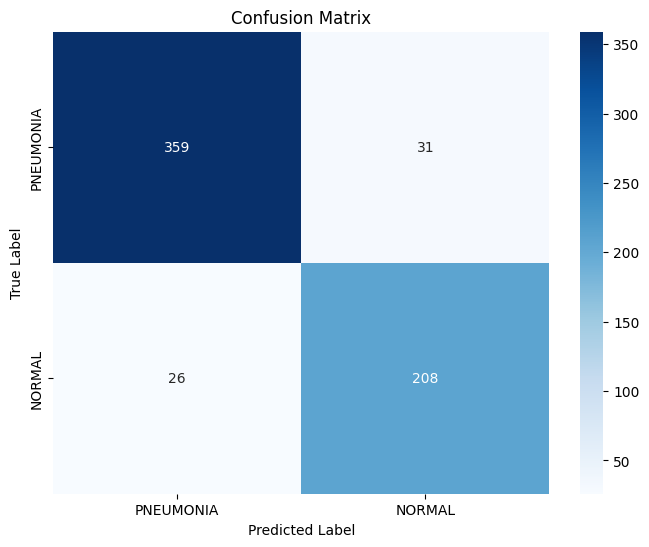

In [34]:
# Evaluating the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

# Making predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Evaluating the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

# Making predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Saving the model
model.save('pneumonia_detection_model.h5')

In [ ]:
# Loading the saved model
loaded_model = tf.keras.models.load_model('pneumonia_detection_model.h5')

# Evaluating the loaded model
test_loss, test_acc = loaded_model.evaluate(X_test, y_test, verbose=2)
print(f"Loaded model test accuracy: {test_acc:.4f}")

In [ ]:
# Plotting training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()